In [71]:
import pandas  as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_theme()


In [72]:
df=pd.read_csv("D:\\INSEA\\Stage PFA\\Stage Ministère de finance\\data\\tourism\\TES+marrakech_lag_1.csv" )
df=df[['date','TES']]
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df = df.asfreq('MS')  # MS = Month Start
df = df.sort_index()

In [73]:
df

,TES
date,
2010-01-01,291608.0
2010-02-01,327017.0
2010-03-01,437338.0
2010-04-01,432338.0
2010-05-01,430974.0
...,...
2024-12-01,784192.0
2025-01-01,624848.0
2025-02-01,761377.0


In [74]:
#df=df[:120]

## EDA

In [75]:
# df['Date'] = pd.to_datetime(df['Date'])

# # Créer la plage de dates manquantes pour 2020 (12 mois)
# missing_2020 = pd.date_range(start='2020-01-01', end='2020-12-01', freq='MS')

# # Créer un DataFrame avec les dates manquantes et valeur 0
# df_missing = pd.DataFrame({'Date': missing_2020, 'value': 0})

# # Fusionner avec ton DataFrame d'origine
# df_full = pd.concat([df, df_missing], ignore_index=True)
# df_full = df_full.sort_values('Date').reset_index(drop=True)
# df_full=df_full.drop('value',axis=1)
# df=df_full

In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 184 entries, 2010-01-01 to 2025-04-01
Freq: MS
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   TES     184 non-null    float64
dtypes: float64(1)
memory usage: 2.9 KB


In [77]:
df.describe()

,TES
count,184.000000
mean,447205.206522
std,190055.770198
min,0.000000
25%,382129.000000
50%,466409.000000
75%,542041.250000
max,966724.000000


In [78]:
# Graphique interactif
fig = px.line(
    df,
    x=df.index,
    y='TES',  # remplace 'value' par le nom réel de ta colonne
    title='Évolution mensuelle des arrivées des touristes étrangers de séjour (TES)',
)

# Personnalisation du style
#fig.update_traces(line=dict(color='sky blue', width=2), opacity=0.8)

fig.show()

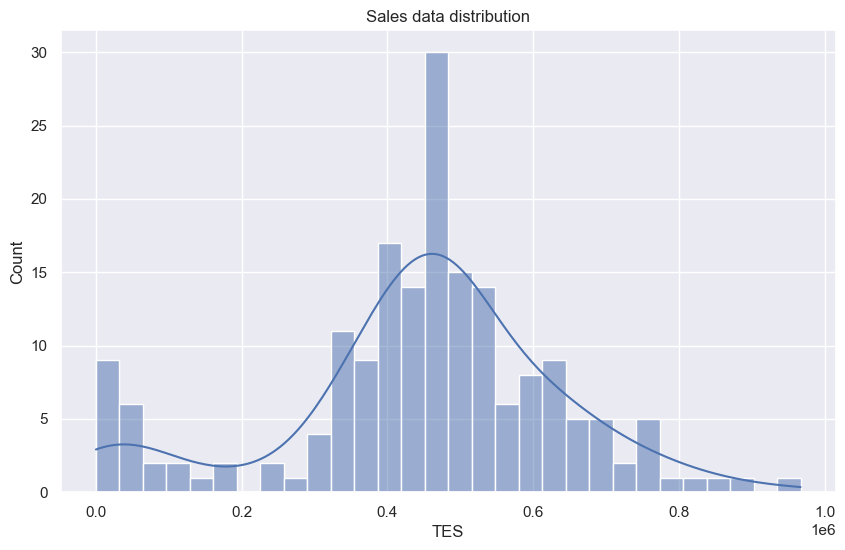

In [79]:
plt.figure(figsize=(10,6))
sns.histplot(df['TES'], kde=True, bins=30)
plt.title("Sales data distribution")
plt.show()

In [80]:
s = pd.to_numeric(df['TES'], errors="coerce").dropna()
nbins = 30

counts, edges = np.histogram(s, bins=nbins)
w = edges[1] - edges[0]
xbar = (edges[:-1] + edges[1:]) / 2

x = np.linspace(s.min(), s.max(), 400)
kde_counts = gaussian_kde(s)(x) * len(s) * w

fig = go.Figure([
    go.Bar(x=xbar, y=counts, width=w, marker_color="#9AC2F7", marker_line=dict(color="white", width=1), name="Count"),
    go.Scatter(x=x, y=kde_counts, mode="lines",marker_color="#144E9A", line=dict(width=2), name="KDE")
])
fig.update_layout(title="Distribution de TES", xaxis_title="TES", yaxis_title="Count", template="simple_white", width=900, height=520)
fig.update_xaxes(showgrid=True)
fig.update_yaxes(showgrid=True)
fig.show()

##### Time series decomposition

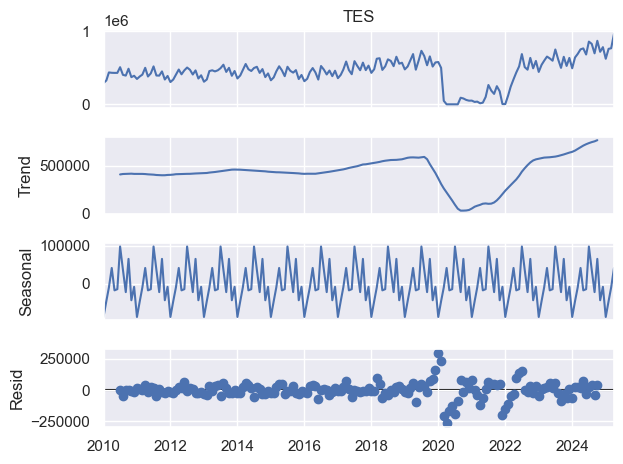

In [81]:
# Seasonal Decomposition
try:
    from statsmodels.tsa.seasonal import seasonal_decompose

    
    result = seasonal_decompose(df['TES'].dropna(), model='additive', period=12)
    result.plot()
    plt.show()
except ImportError:
    print("Statsmodels not installed. Skipping seasonal decomposition.")


#### Augmented Dickey-Fuller test

In [82]:
def test_stationnarite(serie, nom='Serie'):
    result = adfuller(serie.dropna())
    print(f'--- ADF Test fot {nom} ---')
    print(f'ADF Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    
    if result[1] <= 0.05:
        print("✓ Série STATIONNAIRE (p-value ≤ 0.05)")
    else:
        print("✗ Série NON-STATIONNAIRE (p-value > 0.05)")    

In [83]:
test_stationnarite(df['TES'], 'TES')

--- ADF Test fot TES ---
ADF Statistic: -2.3420
p-value: 0.1588
✗ Série NON-STATIONNAIRE (p-value > 0.05)


In [84]:
df['TES_diff1'] = df['TES'].diff()
test_stationnarite(df['TES_diff1'], 'TES_diff1')

--- ADF Test fot TES_diff1 ---
ADF Statistic: -2.7580
p-value: 0.0645
✗ Série NON-STATIONNAIRE (p-value > 0.05)


In [85]:
df['TES_diff2'] = df['TES'].diff().diff()
test_stationnarite(df['TES_diff2'], 'TES_diff1')

--- ADF Test fot TES_diff1 ---
ADF Statistic: -10.7011
p-value: 0.0000
✓ Série STATIONNAIRE (p-value ≤ 0.05)


In [86]:
df

,TES,TES_diff1,TES_diff2
date,,,
2010-01-01,291608.0,NaN,NaN
2010-02-01,327017.0,35409.0,NaN
2010-03-01,437338.0,110321.0,74912.0
2010-04-01,432338.0,-5000.0,-115321.0
2010-05-01,430974.0,-1364.0,3636.0
...,...,...,...
2024-12-01,784192.0,63725.0,214707.0
2025-01-01,624848.0,-159344.0,-223069.0
2025-02-01,761377.0,136529.0,295873.0


In [87]:
ts_d1 = df['TES'].diff().dropna()
ts_d12 = ts_d1.diff(12).dropna()
print("ADF p-value (1st + seasonal diff):", adfuller(ts_d12)[1])

ADF p-value (1st + seasonal diff): 6.305047714926621e-05


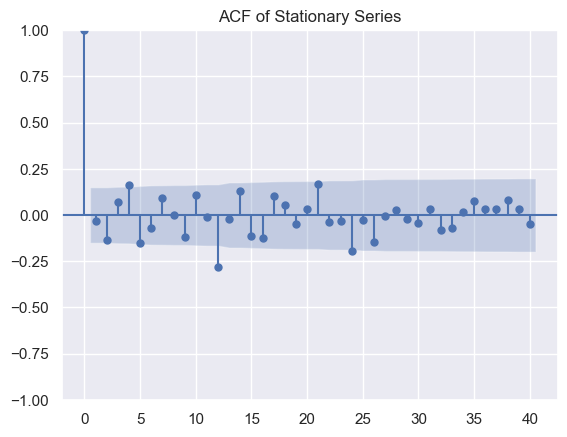

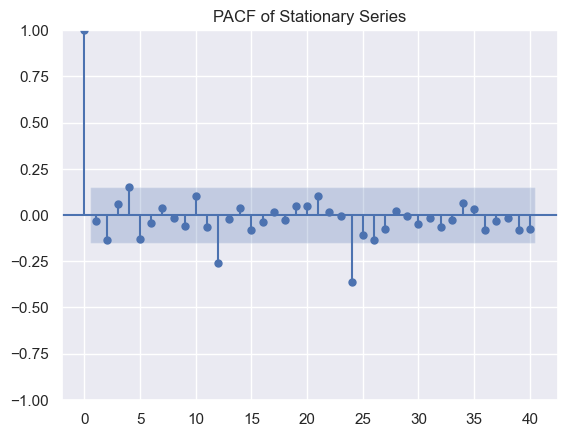

In [88]:
plot_acf(ts_d12,lags=40)
plt.title("ACF of Stationary Series")
plt.show()

plot_pacf(ts_d12,lags=40)
plt.title("PACF of Stationary Series")
plt.show()

## Modeling

In [89]:
df.isnull().sum()

TES          0
TES_diff1    1
TES_diff2    2
dtype: int64

#### Premier décomposition 

In [90]:
train_a=df.loc['01-2010':'02-2020']
test_a=df.loc['03-2020':]
print("taille du train:",len(train_a),"\ntaille du test :",len(test_a))

taille du train: 122 
taille du test : 62


#### deuxiéme decomposition

In [91]:
train_b=df.loc['01-2010':'10-2022']
test_b=df.loc['11-2022':]
print("taille du train:",len(train_b),"\ntaille du test :",len(test_b))

taille du train: 154 
taille du test : 30


#### troisiéme décomposition

In [92]:
train_c=df.loc['01-2010':'01-2024']
test_c=df.loc['02-2024':]
print("taille du train:",len(train_c),"\ntaille du test :",len(test_c))

taille du train: 169 
taille du test : 15


In [ ]:
def grid_search_sarima(train_data, colonne='TES',
                       p_range=range(0, 2), d_range=range(1,2), q_range=range(0, 2),
                       P_range=range(0, 3), D_range=range(1, 3), Q_range=range(0, 3),
                       s=[12]):
    print("\n" + "="*70)
    print("GRID SEARCH SARIMA - VERSION OPTIMISÉE")
    print("="*70)
    # Générer toutes les combinaisons
    pdq = list(itertools.product(p_range, d_range, q_range))
    seasonal_pdq = list(itertools.product(P_range, D_range, Q_range, s))
    
    total_models = len(pdq) * len(seasonal_pdq)
    print(f"\nNombre total de modèles à tester: {total_models}")
    print("Démarrage de la recherche...\n")
    # Variables pour stocker uniquement le meilleur
    meilleur_aic = np.inf
    meilleur_modele = None
    meilleur_params = None
    meilleur_params_seasonal = None
    meilleur_bic = None
    
    compteur = 0
    modeles_testes = 0
    
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            compteur += 1
            
            try:
                # Ajuster le modèle
                model = SARIMAX(train_data[colonne],
                               order=param,
                               seasonal_order=param_seasonal)
                
                results = model.fit(disp=False, maxiter=200)
                modeles_testes += 1
                
                # Garder uniquement si c'est le meilleur
                if results.aic < meilleur_aic:
                    meilleur_aic = results.aic
                    meilleur_bic = results.bic
                    meilleur_modele = results
                    meilleur_params = param
                    meilleur_params_seasonal = param_seasonal
                    
                    # Afficher quand on trouve un meilleur modèle
                    print(f"  ✓ Nouveau meilleur: SARIMA{param}x{param_seasonal} - AIC: {results.aic:.2f}")
                
                # Afficher progression
                if compteur % 10 == 0 or compteur == total_models:
                    print(f"  Progression: {compteur}/{total_models} combinaisons testées ({modeles_testes} réussies)...")
                
            except Exception as e:
                # Ignorer les modèles qui ne convergent pas
                continue
    
    # Vérifier qu'au moins un modèle a convergé
    if meilleur_modele is None:
        raise ValueError("❌ Aucun modèle n'a convergé ! Essayez avec des plages de paramètres différentes.")
    
    print("\n" + "="*70)
    print("🏆 MEILLEUR MODÈLE TROUVÉ")
    print("="*70)
    print(f"SARIMA{meilleur_params}x{meilleur_params_seasonal}")
    print(f"AIC: {meilleur_aic:.2f}")
    print(f"BIC: {meilleur_bic:.2f}")
    print(f"\nModèles testés avec succès: {modeles_testes}/{total_models}")
    
    return {
        'params': meilleur_params,
        'seasonal_params': meilleur_params_seasonal,
        'aic': meilleur_aic,
        'bic': meilleur_bic,
        'model': meilleur_modele
    }

#####  optimal orders

##### 1er décomposition 

In [94]:
meilleur = grid_search_sarima(train_a)


GRID SEARCH SARIMA - VERSION OPTIMISÉE

Nombre total de modèles à tester: 144
Démarrage de la recherche...

  ✓ Nouveau meilleur: SARIMA(0, 1, 0)x(0, 1, 0, 12) - AIC: 2651.22
  ✓ Nouveau meilleur: SARIMA(0, 1, 0)x(0, 2, 0, 12) - AIC: 2425.54
  ✓ Nouveau meilleur: SARIMA(0, 1, 0)x(0, 2, 1, 12) - AIC: 2384.02
  Progression: 10/144 combinaisons testées (10 réussies)...
  ✓ Nouveau meilleur: SARIMA(0, 1, 0)x(1, 2, 1, 12) - AIC: 2381.45
  Progression: 20/144 combinaisons testées (20 réussies)...
  ✓ Nouveau meilleur: SARIMA(0, 1, 1)x(0, 2, 1, 12) - AIC: 2344.55
  Progression: 30/144 combinaisons testées (30 réussies)...
  Progression: 40/144 combinaisons testées (40 réussies)...
  Progression: 50/144 combinaisons testées (50 réussies)...
  Progression: 60/144 combinaisons testées (60 réussies)...
  Progression: 70/144 combinaisons testées (70 réussies)...
  Progression: 80/144 combinaisons testées (80 réussies)...
  Progression: 90/144 combinaisons testées (90 réussies)...
  Progression: 1

##### Fiting Models

In [95]:
model = SARIMAX(train_a["TES"],order=meilleur['params'],seasonal_order=meilleur['seasonal_params'])

In [96]:
results = model.fit(disp=False)
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                TES   No. Observations:                  122
Model:             SARIMAX(0, 1, 1)x(0, 2, 1, 12)   Log Likelihood               -1169.276
Date:                            Sat, 18 Oct 2025   AIC                           2344.553
Time:                                    12:12:31   BIC                           2352.277
Sample:                                01-01-2010   HQIC                          2347.676
                                     - 02-01-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7028      0.123     -5.732      0.000      -0.943      -0.463
ma.S.L12      -0.8358      0.194   

##### Predictions

In [97]:
predictions = results.predict(start=test_a.index[0], end=test_a.index[-1])

##### Metrics

In [98]:
rmse = root_mean_squared_error(test_a['TES'], predictions)
r2 = r2_score(test_a['TES'], predictions)
mae = mean_absolute_error(test_a['TES'], predictions)
mape = mean_absolute_percentage_error(test_a['TES'], predictions)

print("="*15,"Metrics Test","="*15)
print(f"RMSE: {rmse:,.2f}")
print(f"MAE: {mae:,.2f}")
print(f"MAPE: {mape:,.2%}")
print(f"R²: {r2:.2%}")
print(f"R²: {r2:.4f}")

=============== Metrics Test ===============
RMSE: 372,001.58
MAE: 290,820.45
MAPE: 23,903,092,613,060,755,456,000.00%
R²: -53.69%
R²: -0.5369


##### Visualization


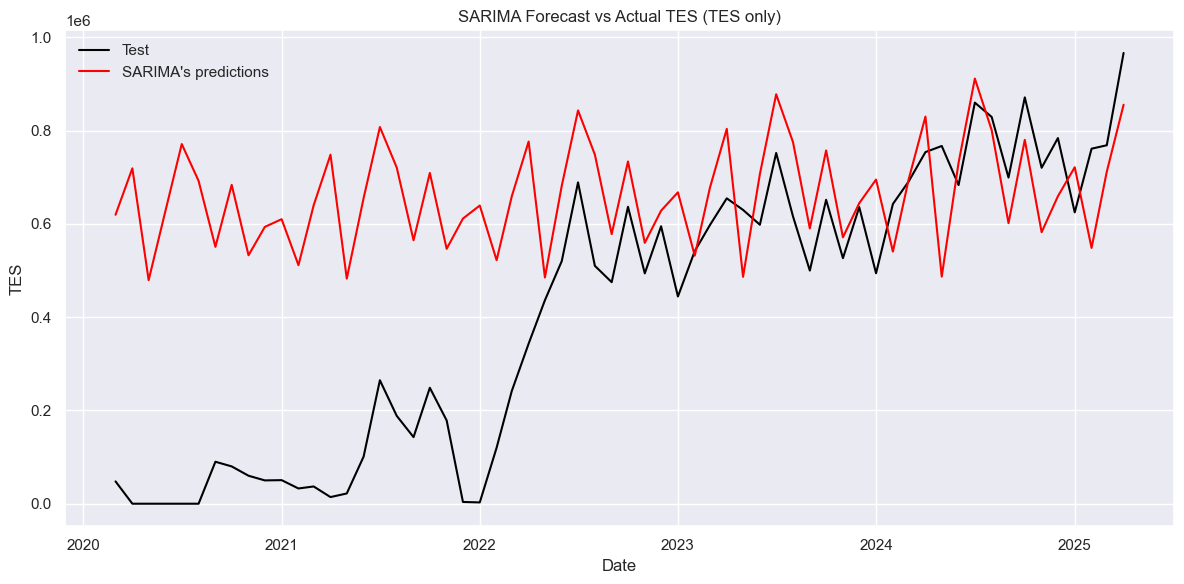

In [99]:
#Visualization
plt.figure(figsize=(12,6))
plt.plot(test_a.index, test_a['TES'], label='Test', color='black')
plt.plot(predictions.index, predictions, label='SARIMA\'s predictions', color='red')
plt.title("SARIMA Forecast vs Actual TES (TES only)")
plt.xlabel("Date")
plt.ylabel("TES")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

##### 2eme décomposition 

In [100]:
meilleur = grid_search_sarima(train_b)


GRID SEARCH SARIMA - VERSION OPTIMISÉE

Nombre total de modèles à tester: 144
Démarrage de la recherche...

  ✓ Nouveau meilleur: SARIMA(0, 1, 0)x(0, 1, 0, 12) - AIC: 3611.63
  ✓ Nouveau meilleur: SARIMA(0, 1, 0)x(0, 1, 1, 12) - AIC: 3591.86
  ✓ Nouveau meilleur: SARIMA(0, 1, 0)x(0, 2, 0, 12) - AIC: 3431.02
  ✓ Nouveau meilleur: SARIMA(0, 1, 0)x(0, 2, 1, 12) - AIC: 3353.35
  Progression: 10/144 combinaisons testées (10 réussies)...
  ✓ Nouveau meilleur: SARIMA(0, 1, 0)x(1, 2, 1, 12) - AIC: 3344.50
  ✓ Nouveau meilleur: SARIMA(0, 1, 0)x(2, 2, 1, 12) - AIC: 3332.28
  Progression: 20/144 combinaisons testées (20 réussies)...
  Progression: 30/144 combinaisons testées (30 réussies)...
  Progression: 40/144 combinaisons testées (40 réussies)...
  Progression: 50/144 combinaisons testées (50 réussies)...
  Progression: 60/144 combinaisons testées (60 réussies)...
  Progression: 70/144 combinaisons testées (70 réussies)...
  Progression: 80/144 combinaisons testées (80 réussies)...
  Progres

In [101]:
model = SARIMAX(train_b["TES"],order=meilleur['params'],seasonal_order=meilleur['seasonal_params'])
results = model.fit(disp=False)
predictions = results.predict(start=test_b.index[0], end=test_b.index[-1])

In [102]:
rmse = root_mean_squared_error(test_b['TES'], predictions)
r2 = r2_score(test_b['TES'], predictions)
mae = mean_absolute_error(test_b['TES'], predictions)
mape = mean_absolute_percentage_error(test_b['TES'], predictions)

print("="*15,"Metrics Test","="*15)
print(f"RMSE: {rmse:,.2f}")
print(f"MAE: {mae:,.2f}")
print(f"MAPE: {mape:,.2%}")
print(f"R²: {r2:.2%}")
print(f"R²: {r2:.4f}")

=============== Metrics Test ===============
RMSE: 120,073.34
MAE: 94,927.15
MAPE: 14.14%
R²: 4.35%
R²: 0.0435


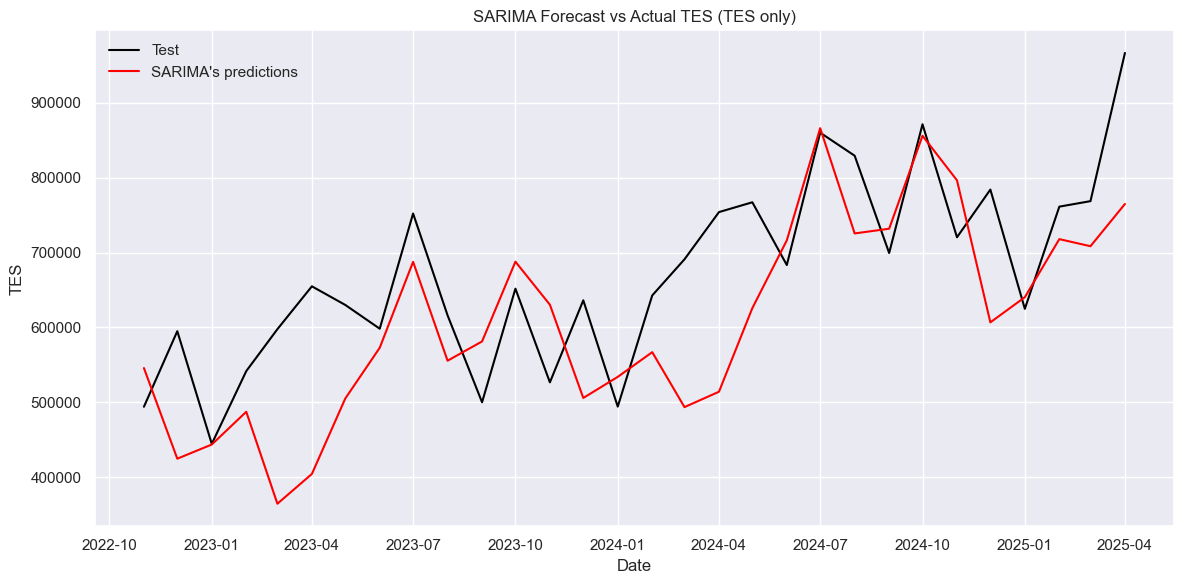

In [103]:
#Visualization
plt.figure(figsize=(12,6))
plt.plot(test_b.index, test_b['TES'], label='Test', color='black')
plt.plot(predictions.index, predictions, label='SARIMA\'s predictions', color='red')
plt.title("SARIMA Forecast vs Actual TES (TES only)")
plt.xlabel("Date")
plt.ylabel("TES")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

##### 3eme décomposition 

In [104]:
meilleur = grid_search_sarima(train_c)


GRID SEARCH SARIMA - VERSION OPTIMISÉE

Nombre total de modèles à tester: 144
Démarrage de la recherche...

  ✓ Nouveau meilleur: SARIMA(0, 1, 0)x(0, 1, 0, 12) - AIC: 3999.66
  ✓ Nouveau meilleur: SARIMA(0, 1, 0)x(0, 1, 1, 12) - AIC: 3971.40
  ✓ Nouveau meilleur: SARIMA(0, 1, 0)x(0, 2, 0, 12) - AIC: 3838.65
  ✓ Nouveau meilleur: SARIMA(0, 1, 0)x(0, 2, 1, 12) - AIC: 3745.19
  Progression: 10/144 combinaisons testées (10 réussies)...
  ✓ Nouveau meilleur: SARIMA(0, 1, 0)x(1, 2, 1, 12) - AIC: 3737.90
  ✓ Nouveau meilleur: SARIMA(0, 1, 0)x(2, 2, 1, 12) - AIC: 3725.89
  Progression: 20/144 combinaisons testées (20 réussies)...
  Progression: 30/144 combinaisons testées (30 réussies)...
  Progression: 40/144 combinaisons testées (40 réussies)...
  Progression: 50/144 combinaisons testées (50 réussies)...
  Progression: 60/144 combinaisons testées (60 réussies)...
  Progression: 70/144 combinaisons testées (70 réussies)...
  Progression: 80/144 combinaisons testées (80 réussies)...
  Progres

In [105]:
model = SARIMAX(train_c["TES"],order=meilleur['params'],seasonal_order=meilleur['seasonal_params'])
results = model.fit(disp=False)
predictions = results.predict(start=test_c.index[0], end=test_c.index[-1])

In [106]:
rmse = root_mean_squared_error(test_c['TES'], predictions)
r2 = r2_score(test_c['TES'], predictions)
mae = mean_absolute_error(test_c['TES'], predictions)
mape = mean_absolute_percentage_error(test_c['TES'], predictions)

print("="*15,"Metrics Test","="*15)
print(f"RMSE: {rmse:,.2f}")
print(f"MAE: {mae:,.2f}")
print(f"MAPE: {mape:,.2%}")
print(f"R²: {r2:.2%}")
print(f"R²: {r2:.4f}")

=============== Metrics Test ===============
RMSE: 72,007.72
MAE: 64,118.02
MAPE: 8.33%
R²: 34.42%
R²: 0.3442


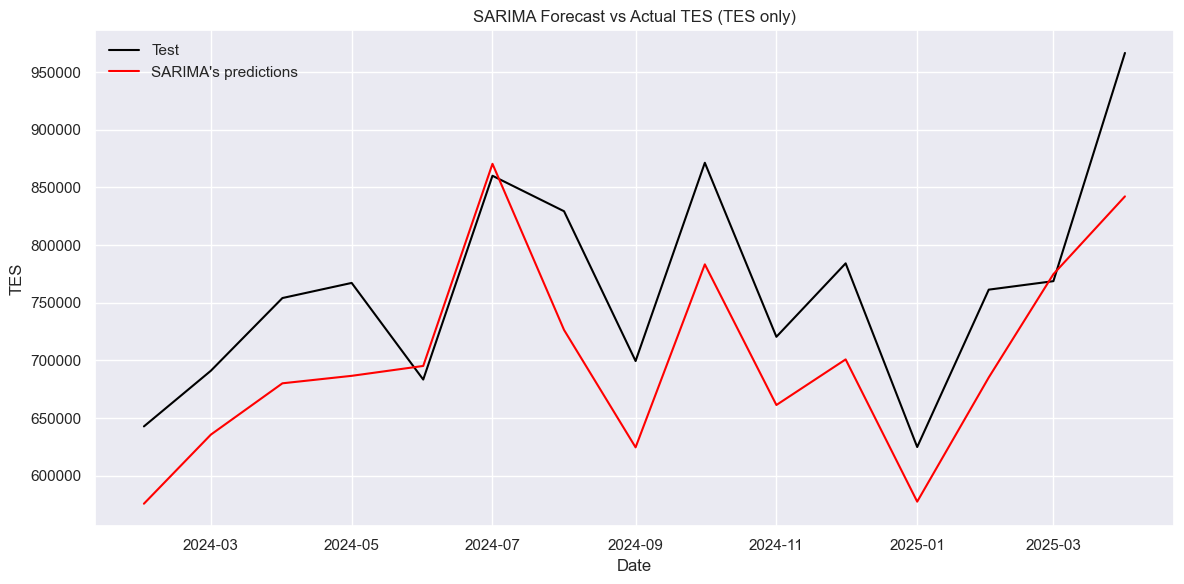

In [107]:
#Visualization
plt.figure(figsize=(12,6))
plt.plot(test_c.index, test_c['TES'], label='Test', color='black')
plt.plot(predictions.index, predictions, label='SARIMA\'s predictions', color='red')
plt.title("SARIMA Forecast vs Actual TES (TES only)")
plt.xlabel("Date")
plt.ylabel("TES")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()